In [27]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [28]:
# Cargar df
df_distancias = pd.read_csv("/content/df_distancias.csv")
df_proveedor = pd.read_csv("/content/df_distancias_proveedores.csv")

In [29]:
#Preprocesamiento
df_distancias.index = df_distancias.iloc[:, 0]
df_distancias = df_distancias.drop(columns=df_distancias.columns[0])
df_proveedor.index = df_proveedor.iloc[:, 0]
df_proveedor = df_proveedor.drop(columns=df_proveedor.columns[0])


coords_sucursales = df_distancias.index.tolist()
coords_centros = df_distancias.columns.tolist()
coords_proveedores = df_proveedor.index.tolist()

distancias_suc_cedis = df_distancias.to_numpy()
distancias_prov_cedis = df_proveedor["distancia_proveedor"].to_numpy()
costos_fijos = df_proveedor["Costo inicial"].to_numpy()

In [44]:
# configuración del modelo
NUM_CEDIS = 5
NUM_PROVEEDORES = 3
ITERACIONES_GRASP = 40
VECINOS_TABU = 10
LONGITUD_TABU = 10

In [45]:
# Funciones
def asignar_sucursales(CEDIS):
    asignaciones = [[] for _ in range(len(CEDIS))]
    for i in range(distancias_suc_cedis.shape[0]):
        distancias = [distancias_suc_cedis[i, c] for c in CEDIS]
        centro_idx = np.argmin(distancias)
        asignaciones[centro_idx].append(i)
    return asignaciones

def elegir_mejores_proveedores(CEDIS):
    total_distancias = []
    for i in range(50):
        total = sum([abs(distancias_prov_cedis[i] - distancias_prov_cedis[c]) for c in CEDIS])
        total_distancias.append((i, total))
    mejores = sorted(total_distancias, key=lambda x: x[1])[:NUM_PROVEEDORES]
    return [i for i, _ in mejores]

def calcular_costo(CEDIS, PROVEEDORES, asignaciones):
    distancias_cedis_carnicerias = sum(
        [distancias_suc_cedis[m, n] for n, m_list in zip(CEDIS, asignaciones) for m in m_list]
    )
    distancias_prov_cedis_total = sum(distancias_prov_cedis[CEDIS])
    costos_totales_apertura = sum(costos_fijos[CEDIS])

    costo_1 = distancias_cedis_carnicerias * 52 * (25 / 6000)
    costo_2 = distancias_prov_cedis_total * 12 * (25 / 6000)
    costo_3 = distancias_cedis_carnicerias * 52 * (5 / 1000)
    costo_4 = distancias_prov_cedis_total * 12 * (5 / 1000)

    return costos_totales_apertura + costo_1 + costo_2 + costo_3 + costo_4



In [46]:
# GRASP + búsqueda tabú
def grasp_tabu():
    mejor_solucion = None
    mejor_costo = float('inf')
    memoria_tabu = []

    for _ in range(ITERACIONES_GRASP):
        CEDIS = random.sample(range(50), NUM_CEDIS)
        asignaciones = asignar_sucursales(CEDIS)
        proveedores = elegir_mejores_proveedores(CEDIS)
        costo = calcular_costo(CEDIS, proveedores, asignaciones)

        for _ in range(VECINOS_TABU):
            vecino = CEDIS.copy()
            i = random.randint(0, NUM_CEDIS - 1)
            posibles = list(set(range(50)) - set(vecino))
            vecino[i] = random.choice(posibles)
            vecino = sorted(vecino)
            if vecino in memoria_tabu:
                continue
            memoria_tabu.append(vecino)
            if len(memoria_tabu) > LONGITUD_TABU:
                memoria_tabu.pop(0)

            asignaciones_v = asignar_sucursales(vecino)
            proveedores_v = elegir_mejores_proveedores(vecino)
            costo_v = calcular_costo(vecino, proveedores_v, asignaciones_v)

            if costo_v < costo:
                CEDIS = vecino
                asignaciones = asignaciones_v
                proveedores = proveedores_v
                costo = costo_v

        if costo < mejor_costo:
            mejor_solucion = (CEDIS, proveedores, asignaciones)
            mejor_costo = costo

    return mejor_solucion, mejor_costo


CEDIS seleccionados: [4, 15, 26, 34, 45]
Proveedores seleccionados: [26, 44, 39]
Costo mínimo encontrado: 58942485.24


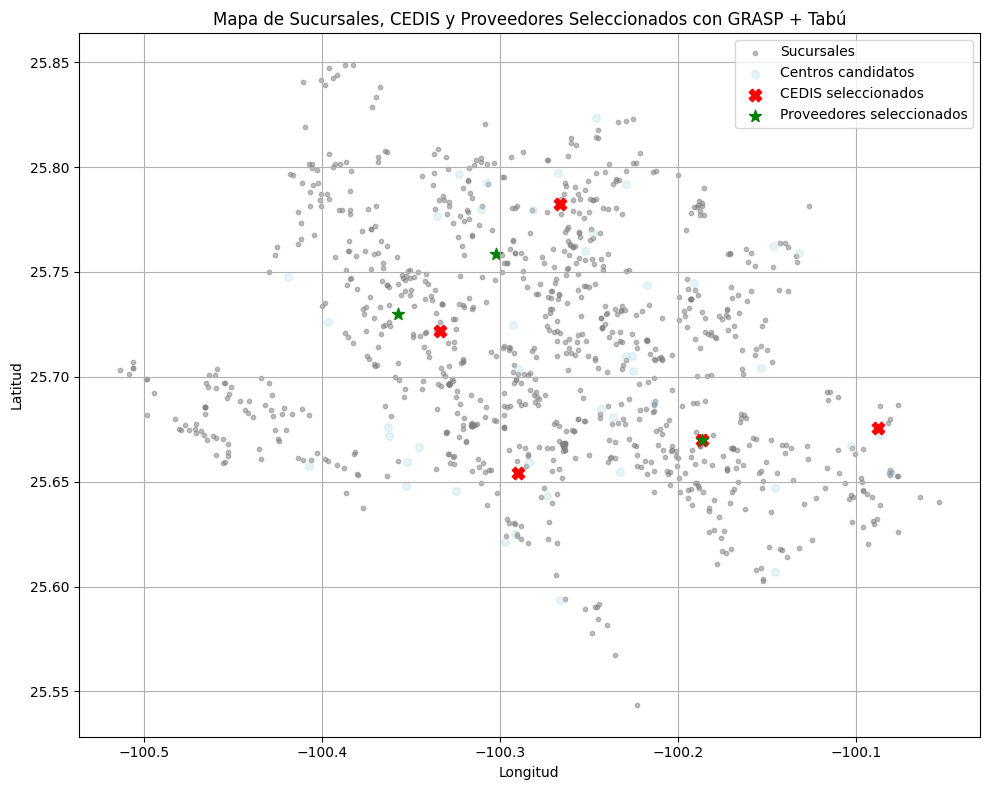

In [47]:
# Ejecución
(mejor_CEDIS, mejor_PROVEEDORES, mejor_asignacion), mejor_costo = grasp_tabu()
print("CEDIS seleccionados:", mejor_CEDIS)
print("Proveedores seleccionados:", mejor_PROVEEDORES)
print("Costo mínimo encontrado:", round(mejor_costo, 2))

# Extraer coordenadas
sucursal_coords = np.array([eval(coord) for coord in coords_sucursales])
centro_coords = np.array([eval(coord) for coord in coords_centros])
proveedor_coords = np.array([eval(coord) for coord in coords_proveedores])
cedis_coords = centro_coords[mejor_CEDIS]
proveedor_coords_sel = proveedor_coords[mejor_PROVEEDORES]

# Visualización
plt.figure(figsize=(10, 8))
plt.scatter(sucursal_coords[:, 0], sucursal_coords[:, 1], c='gray', s=10, label='Sucursales', alpha=0.5)
plt.scatter(centro_coords[:, 0], centro_coords[:, 1], c='lightblue', s=30, label='Centros candidatos', alpha=0.3)
plt.scatter(cedis_coords[:, 0], cedis_coords[:, 1], c='red', s=80, label='CEDIS seleccionados', marker='X')
plt.scatter(proveedor_coords_sel[:, 0], proveedor_coords_sel[:, 1], c='green', s=80, label='Proveedores seleccionados', marker='*')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de Sucursales, CEDIS y Proveedores Seleccionados con GRASP + Tabú')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Asignación por CEDIS

for i, asignados in enumerate(mejor_asignacion):
    print(f"CEDIS {mejor_CEDIS[i]} atiende a {len(asignados)} sucursales")

distancias = [distancias_suc_cedis[m, mejor_CEDIS[i]] for i, lista in enumerate(mejor_asignacion) for m in lista]
print(f"Distancia promedio sucursal–CEDIS: {np.mean(distancias):.2f} m")


CEDIS 4 atiende a 237 sucursales
CEDIS 15 atiende a 302 sucursales
CEDIS 26 atiende a 205 sucursales
CEDIS 34 atiende a 157 sucursales
CEDIS 45 atiende a 46 sucursales
Distancia promedio sucursal–CEDIS: 8523.87 m


In [49]:
# Reporte de asignaciónes
asignacion_data = []
for i, cedis_idx in enumerate(mejor_CEDIS):
    for suc in mejor_asignacion[i]:
        coord_suc = coords_sucursales[suc]
        dist = distancias_suc_cedis[suc, cedis_idx]
        asignacion_data.append({
            'Sucursal_ID': suc,
            'Sucursal_Coord': coord_suc,
            'CEDIS_ID': cedis_idx,
            'CEDIS_Coord': coords_centros[cedis_idx],
            'Distancia_m': dist
        })
df_asignacion = pd.DataFrame(asignacion_data)
df_asignacion.to_excel("asignacion_cedis.xlsx", index=False)